In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=40)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=20)
parser.add_argument("--Re", type=int, default=100)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Single")
parser.add_argument("--Mach", type=float, default=0.05)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
print(collision_operator)
print(torch.version.cuda)

ICH FUNKTIONIERE MIT PULLEN
BGK
12.1


In [3]:
print(Precision)
lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=torch.float32 if Precision == "Single" else torch.float64)
flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice)
print(flow.units.convert_time_to_lu(tmax))
tensor=torch.tensor(1)
print(tensor.dtype)
# Konstruktion des Funktionsnamens
function_name = f"{collision_operator}Collision"

# Überprüfung, ob die Funktion existiert, und deren Aufruf
#if hasattr(lt, function_name):
#    collision = getattr(lt, function_name)(lattice, tau=flow.units.relaxation_parameter_lu)
#    print(collision_operator)
#else:
#    print(":(((")
#    raise ValueError(f"Collision type {collision_operator} is not supported.")
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)
#collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
#collision=collision_type(lattice, tau=flow.units.relaxation_parameter_lu)
print(flow.units.relaxation_parameter_lu)
print(flow.units.viscosity_pu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


Single
4410.631163374336
torch.int64
0.5055132889542179
0.01
torch.float32
torch.float32


In [4]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/20)
interval_out=int((flow.units.convert_time_to_lu(tmax))/500)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)
Energyspectrum= lt.EnergySpectrum(lattice, flow)
Symmetrie= lt.SymmetryReporter(lattice,flow)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2 = lt.ObservableReporter(Dissipation_TGV,interval = interval_out, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=interval_out, out=None)
reporter4=lt.ObservableReporter(Energyspectrum, interval=interval_out, out=None)
reporter5 = lt.ObservableReporter(Symmetrie, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
simulation.reporters.append(reporter4)
simulation.reporters.append(reporter5)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps = int(flow.units.convert_time_to_lu(tmax))
print(steps)

#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
steps     time     EnergySpectrum
steps     time     SymmetryReporter
4410


/home/ben/anaconda3/envs/lettuce/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))

mlups = simulation.step(num_steps=steps)
print("Performance in MLUPS:", mlups)
print(steps)

torch.float32
torch.float32
tensor([3.9513e-08, 3.9513e-08, 3.9513e-08, 3.9513e-08, 3.9348e-08, 3.9348e-08,
        3.9348e-08, 3.9348e-08])
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
tensor([2.8511e-07, 2.8511e-07, 2.8511e-07, 2.8511e-07, 2.6744e-07, 2.6744e-07,
        2.6744e-07, 2.6744e-07])
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
tensor([3.9688e-07, 3.9688e-07, 3.9688e-07, 3.9688e-07, 4.4449e-07, 4.4449e-07,
        4.4449e-07, 4.4449e-07])
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
tor

In [6]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)
energy_spectrum= np.array(simulation.reporters[3].out)

sym = np.array(simulation.reporters[4].out) #ÄNDERN ZU 4 WEGEN ENERGIESPEKTRUM



dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*2)**3])
dissipationEns=np.array([enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)
with open(csvdir + 'EnergySpectrum.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(energy_spectrum)
with open(csvdir + 'Symmetrie.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(sym)


[31.0062809  30.94289207 30.87768936 30.81184769 30.74641609 30.67715454
 30.60897255 30.54065704 30.47235489 30.4060936  30.33914948 30.27225685
 30.20536041 30.13741875 30.0696373  30.00161934 29.93344116 29.86559105
 29.79749489 29.72927475 29.66080475 29.59197044 29.52296638 29.45358658
 29.38404274 29.31433487 29.24421501 29.17393112 29.10330009 29.03223038
 28.96091652 28.88916779 28.81702423 28.74459267 28.67172813 28.59841347
 28.52469635 28.45056725 28.37593651 28.30082893 28.2252903  28.14920425
 28.07265472 27.99562645 27.91797829 27.83984756 27.7612114  27.68194962
 27.60213852 27.52177238 27.44081116 27.35925865 27.2771244  27.19433975
 27.11095619 27.02701569 26.94238663 26.85711288 26.77126122 26.68475723
 26.59758759 26.50980186 26.42135429 26.33225441 26.2425518  26.15217209
 26.06111145 25.96947479 25.87718582 25.78421783 25.69063759 25.59642601
 25.50156403 25.40611649 25.31002235 25.21328163 25.11598206 25.01807976
 24.9195385  24.82042503 24.72075081 24.62048149 24

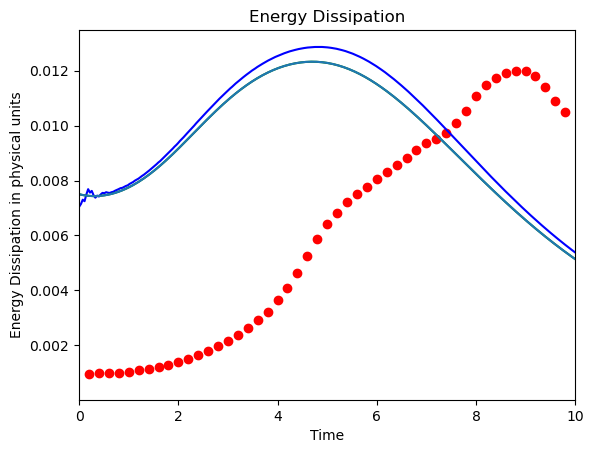

In [9]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re800.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(energy[:,2])
plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
#plt.plot(energy[:,1],energy[:,2])
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Annahme: `energy_spectrum` und andere Variablen sind bereits definiert
energy_spectrum = np.array(simulation.reporters[3].out)

# Erstelle eine neue Figur und Achsen für die Animation
fig, ax = plt.subplots()

# Setze die Achsen auf logarithmische Skalen
ax.set_xscale('log')
ax.set_yscale('log')

# Bereich der x- und y-Achsen festlegen
ax.set_xlim(2, 21)  # Beispielbereich für Wellenlängen
ax.set_ylim(np.min(energy_spectrum[:, 4:23]), np.max(energy_spectrum[:, 4:23]))  # Bereich für das Energiespektrum

# Erstelle das Anfangsplot
line, = ax.plot([], [], lw=2)

# Initialisierungsfunktion: Zeichnet nur den Hintergrund des Plots
def init():
    line.set_data([], [])
    return (line,)

# Animationsfunktion: Diese wird in jedem Frame aufgerufen
def animate(i):
    x = np.arange(2, 21)  # Korrigierte Wellenlängen (x-Achse)
    y = energy_spectrum[i, 4:23]  # Energiespektrum für die Zeit i
    line.set_data(x, y)
    ax.set_title(f'Zeitpunkt: {energy_spectrum[i, 1]:.2f}')  # Titel mit dem Zeitpunkt
    return (line,)

# Erstelle die Animation
ani = FuncAnimation(fig, animate, init_func=init, frames=energy_spectrum.shape[0], interval=100, blit=True)

# Speichern als GIF oder MP4 (optional)
ani.save('/home/ben/Schreibtisch/energy_spectrum_animation.gif', writer='imagemagick')
# ani.save('energy_spectrum_animation.mp4', writer='ffmpeg')

plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (19,) and arg 1 with shape (18,).

<Figure size 640x480 with 1 Axes>

MovieWriter imagemagick unavailable; using Pillow instead.


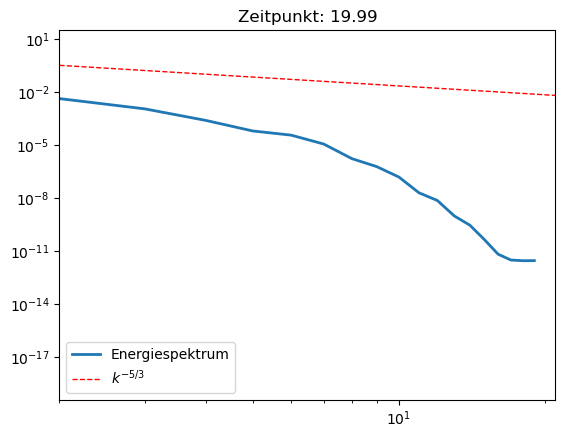

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Annahme: `energy_spectrum` und andere Variablen sind bereits definiert
energy_spectrum = np.array(simulation.reporters[3].out)

# Erstelle eine neue Figur und Achsen für die Animation
fig, ax = plt.subplots()

# Setze die Achsen auf logarithmische Skalen
ax.set_xscale('log')
ax.set_yscale('log')

# Bereich der x-Achse festlegen
ax.set_xlim(2, 21)  # Beispielbereich für Wellenlängen

# Erstelle das Anfangsplot und die Referenzlinie für k^-5/3
line, = ax.plot([], [], lw=2, label='Energiespektrum')
x_kolmogorov = np.linspace(2, 21, 100)  # Wellenzahlen für die Kolmogorov-Gerade
kolmogorov_line, = ax.plot(x_kolmogorov, x_kolmogorov**(-5/3), 'r--', lw=1, label=r'$k^{-5/3}$')  # Kolmogorov-Gerade

ax.legend()

# Initialisierungsfunktion: Zeichnet nur den Hintergrund des Plots
def init():
    line.set_data([], [])
    kolmogorov_line.set_data(x_kolmogorov, x_kolmogorov**(-5/3))  # Setze die Kolmogorov-Gerade
    return line, kolmogorov_line

# Animationsfunktion: Diese wird in jedem Frame aufgerufen
def animate(i):
    x = np.arange(1,20)  # Korrigierte Wellenlängen (x-Achse)
    y = energy_spectrum[i, 3:]/(2*np.pi)**3  # Energiespektrum für die Zeit i
    line.set_data(x, y)
    ax.set_title(f'Zeitpunkt: {energy_spectrum[i, 1]:.2f}')  # Titel mit dem Zeitpunkt

    # Dynamische Anpassung der y-Achse
    y_min = np.min(y[y > 0])  # Ignoriere nicht-positive Werte
    y_max = np.max(energy_spectrum[:, 3:])
    ax.set_ylim(y_min, y_max)  # Aktualisiere die y-Achse basierend auf dem aktuellen Min-Wert

    return line, kolmogorov_line

# Erstelle die Animation
ani = FuncAnimation(fig, animate, init_func=init, frames=energy_spectrum.shape[0], interval=100, blit=True)

# Speichern als GIF oder MP4 (optional)
ani.save('/home/ben/Schreibtisch/energy_spectrum_animation.gif', writer='imagemagick')
# ani.save('energy_spectrum_animation.mp4', writer='ffmpeg')

plt.show()

[8.00000000e+00 3.62759873e-02 9.87644216e-06]


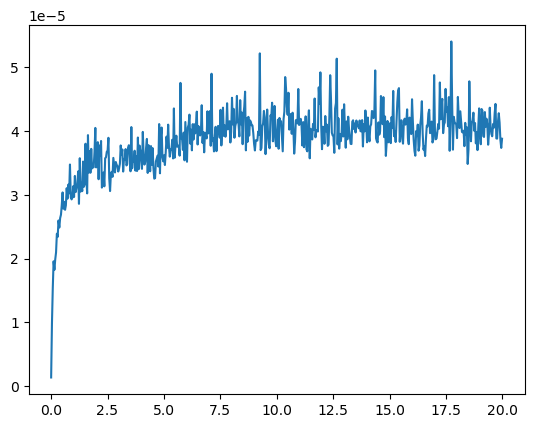

In [11]:
print(sym[1,:])
plt.plot(sym[:,1],sym[:,2])